In [2]:
import json
import numpy as np
from typing import Any, Callable, List, Optional, Tuple, Dict

class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str], # ['soc', 'price', 'net_load', 'solar_generation']
                    action_space: List[str], # ['charge', 'discharge', 'idle'] 
                    rule_defs: List[Dict] = None, 
                    # e.g. [
                    #   {
                    #     "conditions": [
                    #       {"field":"soc","op":"<","threshold_name":"soc_low"}
                    #     ],
                    #     "action":"charge"
                    #   }
                    # ]
                    thresholds: Dict[str, float] = None, # {'soc': 0.2, 'price': 50.0}
                    history: List[Tuple[Dict[str, float], str, float]] = None, # [(observation_dict, action_str, reward_float)]
                    obs_index_map: Optional[Dict[str, int]] = None):   # <--- NEW (optional)
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        self.obs_index_map = obs_index_map or {}                   # <--- NEW

        # Initialize rules from dictionaries
        self.rules = [(self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs]

    def set_obs_index_map(self, mapping: Dict[str, int]):          
        self.obs_index_map = dict(mapping)

    def _ensure_obs_map(self, env):                                 
        if self.obs_index_map:
            return
        names = getattr(env.buildings[0], "active_observations", None)
        if not names:
            raise RuntimeError(
                "obs_index_map missing and env has no observation_names. "
                "Call agent.set_obs_index_map({'soc': i, 'price': j, 'net_load': k, 'solar_generation': m})."
            )
        name_to_idx = {n: i for i, n in enumerate(names)}
        # default aliases
        wanted = {
            "soc": "electrical_storage_soc",
            "price": "electricity_pricing",
            "net_load": "net_electricity_consumption",  # or 'non_shiftable_load'
            "solar_generation": "solar_generation",
        }
        try:
            self.obs_index_map = {k: name_to_idx[wanted[k]] for k in self.obs_keys}
        except KeyError as e:
            raise RuntimeError(
                f"Could not auto-map {e}. "
                f"Available names include: {names[:20]} ..."
            )
    
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        # Rebuild rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    
    def evaluate(self, env, broadcast=False,  max_steps=None) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        self._ensure_obs_map(env)
        episode_history = []
        episode_reward = 0.0
        steps = 0


        done = False
        while not done and (max_steps is None or steps < max_steps):
            # 1) Observations for all buildings -> take building 0 only
            obs_all = env.observations            # List[List[float]]
            obs_vec  = obs_all[0]                         # features of building 0
            #obs_dict = {k: float(b0[i]) for i, k in enumerate(self.obs_keys)}
            obs_dict = {k: float(obs_vec [self.obs_index_map[k]]) for k in self.obs_keys}

            b0 = env.buildings[0]
            ts = b0.time_step
            obs_soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
            obs_dict['soc'] = float(obs_soc)

            # 2) Decide action for building 0
            action = self.act(obs_dict)

            # map the string action to numeric fractions for each storage
            # charge → +1.0, idle → 0.0, discharge → -1.0
            frac_map = { 
                'strong_charge': 1.0, 
                'mild_charge': 0.5, 
                'idle': 0.0, 
                'mild_discharge': -0.5, 
                'strong_discharge': -1.0 } 
            frac = frac_map[action]
            
            # 3) Build central-agent action list: control b0, zeros elsewhere
            N = env.action_space[0].shape[0]

            if broadcast:
                actions = [[float(np.clip(frac, -1.0, 1.0))] * N]
            else:
                flat = [0.0] * N
                flat[0] = float(np.clip(frac, -1.0, 1.0))
                actions = [flat]

            # 4) Step the env and unpack
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)

            # 5) Use only building 0's reward
            step_reward = float(reward_list[0])

            # 6) Log + accumulate
            print(f"{obs_dict}, {action}, {step_reward}")
            episode_history.append((obs_dict, action, step_reward))
            self.history.append((obs_dict, action, step_reward))

            episode_reward += step_reward
            done = bool(terminated) or bool(truncated)

            steps += 1

        return episode_reward, episode_history
    
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        self.histories = []
        for _ in range(episodes):
            print(f"Episode {_ + 1}/{episodes}")
            episode_reward, episode_history = self.evaluate(env)
            self.rewards.append(episode_reward)
            self.histories.append(episode_history)
        return self.rewards, self.histories

In [3]:
import os
import pandas as pd
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv

def keep_only_electrical_storage(schema: dict) -> dict: # Set actions to just electical storage
    # Top-level actions
    if 'actions' in schema:
        for a in list(schema['actions'].keys()):
            schema['actions'][a]['active'] = (a == 'electrical_storage')

    # Per-building overrides, if present
    if 'buildings' in schema:
        for b in schema['buildings']:
            if 'actions' in b:
                for a in list(b['actions'].keys()):
                    b['actions'][a]['active'] = (a == 'electrical_storage')
    return schema

def keep_only_core_observations(schema: dict,
                                core=None,
                                drop_predictions: bool = True,
                                extra_keep=None) -> dict:
    """
    Activate only the minimal observation signals needed by the RBC:
      - electrical_storage_soc  (mapped to 'soc')
      - electricity_pricing     (mapped to 'price')
      - net_electricity_consumption (mapped to 'net_load')
      - solar_generation        (mapped to 'solar_generation')

    Everything else (incl. *_predicted_* if drop_predictions=True) is deactivated.
    Safe no-op for keys not present. Returns the same (mutated) schema.
    """
    default_core = [
        'electrical_storage_soc',
        'electricity_pricing',
        'net_electricity_consumption',
        'solar_generation',
    ]
    if core is None:
        core = list(default_core)
    if extra_keep:
        # allow user to force-retain specific names (e.g. for future reward variants)
        for x in extra_keep:
            if x not in core:
                core.append(x)

    def _deactivate_obs_dict(obs_dict: dict):
        for name, cfg in obs_dict.items():
            if not isinstance(cfg, dict):
                continue
            keep = name in core
            if drop_predictions and '_predicted_' in name:
                keep = False
            # toggle
            if 'active' in cfg:
                cfg['active'] = bool(keep)

    # Top-level observations block (if present)
    if 'observations' in schema and isinstance(schema['observations'], dict):
        _deactivate_obs_dict(schema['observations'])

    # Per-building observations overrides
    if 'buildings' in schema and isinstance(schema['buildings'], dict):
        for bname, bconf in schema['buildings'].items():
            if isinstance(bconf, dict) and 'observations' in bconf and isinstance(bconf['observations'], dict):
                _deactivate_obs_dict(bconf['observations'])

    return schema

"""
# rule_defs e.g. [
#   {
#     "conditions": [
#       {"field":"soc","op":"<","threshold_name":"soc_low"}
#     ],
#     "action":"charge"
#   }
# ]
"""
dataset = DataSet()
schema = dataset.get_schema('citylearn_challenge_2023_phase_3_1')
schema['root_directory'] = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity'], drop_predictions=False)
# Set reward function
schema['reward_function'] = { # CostReward Function
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
# Set pricing file
price_file = 'pricing_germany_2023_june_to_august.csv'  # Pricing CSV
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

five_level_actions = ['strong_charge', 'mild_charge', 'idle', 'mild_discharge', 'strong_discharge']
five_level_rules=[
    # strong charge: soc <= 0.20    
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_empty'}], 
        'action':'strong_charge'},
    # mild charge: 0.20 < soc <= 0.30    
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_empty'}, 
        {'field':'soc','op':'<=','threshold_name':'soc_low'}], 
        'action':'mild_charge'},


    # strong discharge: soc > 0.80 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_high'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'strong_discharge'},
    # mild discharge: soc > 0.80 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_high'},
        {'field':'price','op':'<=','threshold_name':'price'}], 
        'action':'mild_discharge'},
    

    # mild charge: soc <= 0.55 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_mid'},
        {'field':'price','op':'<=','threshold_name':'price'}], 
        'action':'mild_charge'},
    # idle: soc <= 0.55 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_mid'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'idle'},


    # mild discharge: soc > 0.55 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_mid'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'mild_discharge'},
    # idle: soc > 0.55 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_mid'},
        {'field':'price','op':'<=','threshold_name':'price'}],  
        'action':'idle'},
]
thresholds={
    'soc_empty': 0.2, 
    'soc_low': 0.3,
    'soc_mid': 0.55, 
    'soc_high': 0.8, 
    'price': 0.04, 
}
env = CityLearnEnv(schema, central_agent=True)
agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=five_level_actions,
                 rule_defs=five_level_rules,
                 thresholds=thresholds,
                 history=[])

# ---------------------------


# ---------------------------

"""
0: day_type
1: hour
2: outdoor_dry_bulb_temperature
3: outdoor_dry_bulb_temperature_predicted_1
4: outdoor_dry_bulb_temperature_predicted_2
5: outdoor_dry_bulb_temperature_predicted_3
6: diffuse_solar_irradiance
7: diffuse_solar_irradiance_predicted_1
8: diffuse_solar_irradiance_predicted_2
9: diffuse_solar_irradiance_predicted_3
10: direct_solar_irradiance
11: direct_solar_irradiance_predicted_1
12: direct_solar_irradiance_predicted_2
13: direct_solar_irradiance_predicted_3
14: carbon_intensity
15: indoor_dry_bulb_temperature
16: non_shiftable_load
17: solar_generation
18: dwh_storage_soc
19: electrical_storage_soc
20: net_electricity_consumption
21: electricity_pricing
22: electricity_pricing_predicted_1
23: electricity_pricing_predicted_2
24: electricity_pricing_predicted_3
25: cooling demand
26: dwh demand
27: occupant count
28: power_outage
29: indoor_dry_bulb_temperature_cooling_set_point
"""

# evaluate 1 episode
r, hist = agent.evaluate(env, max_steps=1000)  # max steps while debugging

#rewards, histories = agent.multiple_evaluation(env, episodes=30)  

# build logs from 'hist', not agent.history
logs = [{'timestep': t, **obs, 'action': action, 'reward': reward} for t, (obs, action, reward) in enumerate(hist)]
df = pd.DataFrame(logs, columns=['timestep','soc','price','net_load','solar_generation','action','reward'])
df.to_csv('rbc_agent_logs.csv', index=False)

# Debug
print(f"Episode has {len(hist)} timesteps.")
print('Reward function:', type(env.reward_function).__name__)
print(env.schema['buildings'][env.buildings[0].name]['pricing'])

Couldn't import dot_parser, loading of dot files will not be possible.


INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-19_15-20-42'
{'soc': 0.20000000298023224, 'price': 0.08415000140666962, 'net_load': 0.4156108498573303, 'solar_generation': 0.0}, mild_charge, -0.9675724252262281
{'soc': 0.596950888633728, 'price': 0.07429999858140945, 'net_load': 4.566832542419434, 'solar_generation': 0.0}, mild_discharge, -0.20498572480040467
{'soc': 0.1999402642250061, 'price': 0.07010000199079514, 'net_load': -0.9619874954223633, 'solar_generation': 0.0}, strong_charge, -0.5078233104534385
{'soc': 0.9617419838905334, 'price': 0.06672000139951706, 'net_load': 3.623429536819458, 'solar_generation': 0.0}, strong_discharge, -0.16995307762080802
{'soc': 0.599850177

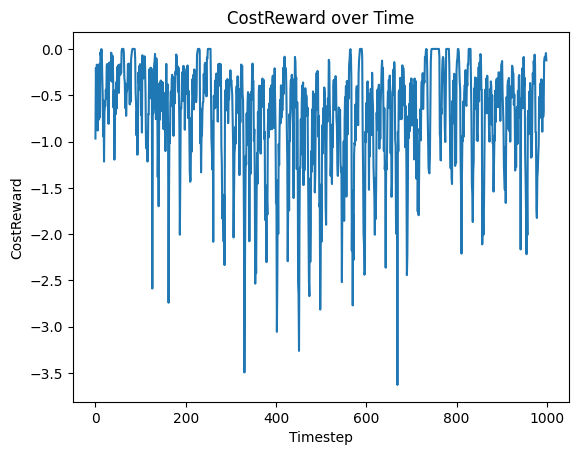

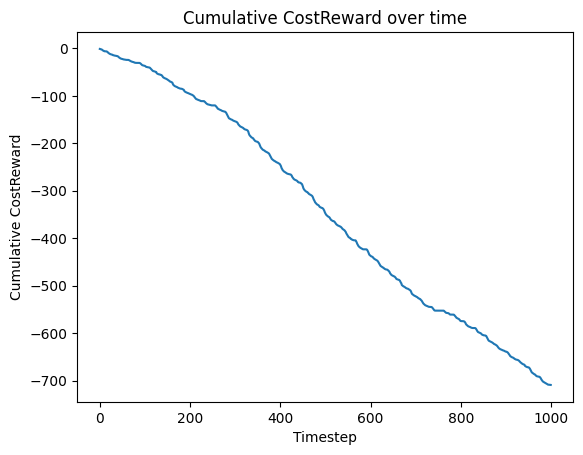

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Attempt to load the log data, handle if file is missing
try:
    df = pd.read_csv('rbc_agent_logs.csv')
except FileNotFoundError:
    print("Log file 'rbc_agent_logs.csv' not found.")
else:
    plt.figure()
    plt.plot(df['timestep'], df['reward'])
    plt.xlabel('Timestep')
    plt.ylabel(f'{type(env.reward_function).__name__}')
    plt.title(f'{type(env.reward_function).__name__} over Time')
    plt.show()

    df['cum_reward'] = df['reward'].cumsum()
    plt.figure()
    plt.plot(df['timestep'], df['cum_reward'])
    plt.xlabel('Timestep'); plt.ylabel(f'Cumulative {type(env.reward_function).__name__}'); plt.title(f'Cumulative {type(env.reward_function).__name__} over time')
    plt.show()

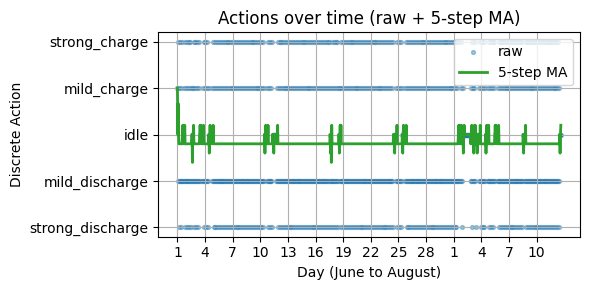

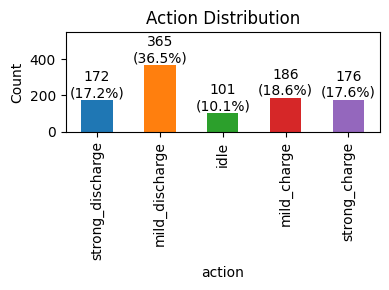

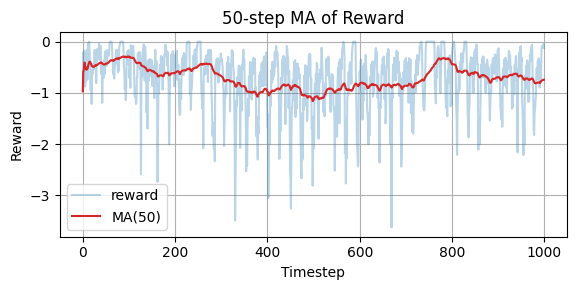

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DayLocator, DateFormatter

# hist: List[(obs_dict, action_str, reward_float)]
ep_logs = []

for t, (obs, act, rew) in enumerate(hist):
    row = {'t': t, 'action': act, 'reward': rew}
    for k in ('soc','price','net_load','solar_generation'):
        if k in obs:
            row[k] = obs[k]
    ep_logs.append(row)
df = pd.DataFrame(ep_logs)

# Action → numerical representation
action_to_frac_5 = { 
    'strong_charge': 1.0, 
    'mild_charge': 0.5, 
    'idle': 0.0, 
    'mild_discharge': -0.5, 
    'strong_discharge': -1.0 }
df['action_num'] = df['action'].map(action_to_frac_5)

# Moving Average
window = 5
df['action_ma'] = df['action_num'].rolling(window, min_periods=1).mean()

# Assumptions:
# - df has column 'timestep' (0.. up to 2207 for full 92 days: June 1 – Aug 31 hourly)

df['day'] = df['t'] // 24
df['date_time'] = pd.Timestamp('2023-06-01') + pd.to_timedelta(df['t'], unit='h')

# ----- Plot 1: Actions over time (raw + MA) -----
plt.figure(figsize=(6,3))
plt.scatter(df['t'], df['action_num'], s=8, alpha=0.4, label='raw')
plt.plot(
    df['t'], 
    df['action_ma'], 
    color='C2', lw=2,
    label=f"{window}-step MA"
)

#plt.xlabel('Timestep'); 
# -----------
ax = plt.gca()
max_t = int(df['t'].max())

# All day boundaries (every 24 timesteps)
start = pd.Timestamp('2023-06-01')
day_ticks = np.arange(0, (max_t // 24) + 1) * 24   # 0,24,48,...
day_labels = (start + pd.to_timedelta(day_ticks, unit='h')).day
ax.set_xticks(day_ticks)

ax.set_xticklabels(day_labels)
ax.set_xlabel('Day (June to August)')

N = 3  
keep_idx = np.arange(0, len(day_ticks), N)
ax.set_xticks(day_ticks[keep_idx])
ax.set_xticklabels(day_labels[keep_idx])
# --------

plt.title(f"Actions over time (raw + {window}-step MA)")
plt.yticks([-1.0,-0.5,0.0,0.5,1.0], 
           ['strong_discharge','mild_discharge','idle','mild_charge','strong_charge'])

plt.ylabel('Discrete Action'); plt.legend(loc="upper right"); plt.grid(True); plt.tight_layout(); plt.show()



# ----- Plot 2: Action Distribution -----
plt.figure(figsize=(4,3))
counts = df['action'].value_counts().reindex(['strong_discharge','mild_discharge','idle','mild_charge','strong_charge']).fillna(0)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()

# ----- Plot 3: Reward over time + Moving Average -----
rw_window = 50
df['reward_ma'] = df['reward'].rolling(rw_window, min_periods=1).mean()
plt.figure(figsize=(6,3))
plt.plot(df['t'], df['reward'], alpha=0.3, label='reward')
plt.plot(df['t'], df['reward_ma'], color='C3', label=f'MA({rw_window})')
plt.xlabel('Timestep'); plt.ylabel('Reward')
plt.title(f'{rw_window}-step MA of Reward')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
"""
# Takes a lil longer
all_ep_rows = []
n_episodes = 10

for ep in range(n_episodes):
    r, hist = agent.evaluate(env)  # komplette Episode
    for t, (obs, act, rew) in enumerate(hist):
        all_ep_rows.append({
            'episode': ep,
            't': t,
            'action': act,
            'reward': rew
        })

multi_df = pd.DataFrame(all_ep_rows)
multi_df['action_num'] = multi_df['action'].map({'charge':1.0,'idle':0.0,'discharge':-1.0})

# Aktionshäufigkeit pro Episode
ep_counts = (multi_df
             .groupby(['episode','action'])
             .size()
             .unstack(fill_value=0)
             .reindex(columns=['charge','idle','discharge'], fill_value=0))

print(ep_counts)

# Gesamte Verteilung
overall = multi_df['action'].value_counts()
print('Overall distribution:', overall.to_dict())


(ep_counts.div(ep_counts.sum(axis=1), axis=0)
          .plot(kind='bar', stacked=True, figsize=(7,3)))
plt.ylabel('Proportion'); plt.title('Aktionsanteile pro Episode')
plt.legend(loc='upper right'); plt.tight_layout(); plt.show()


if len(multi_df):
    multi_df['hour'] = multi_df['t'] % 24
    pivot = (multi_df
             .groupby(['hour','action'])
             .size()
             .unstack(fill_value=0)
             .reindex(columns=['charge','idle','discharge'], fill_value=0))
    pivot.plot(kind='bar', stacked=True, figsize=(8,3))
    plt.title('Aktionsverteilung nach Stunde (t % 24)')
    plt.xlabel('Hour'); plt.ylabel('Count')
    plt.tight_layout(); plt.show()

"""

"\n# Takes a lil longer\nall_ep_rows = []\nn_episodes = 10\n\nfor ep in range(n_episodes):\n    r, hist = agent.evaluate(env)  # komplette Episode\n    for t, (obs, act, rew) in enumerate(hist):\n        all_ep_rows.append({\n            'episode': ep,\n            't': t,\n            'action': act,\n            'reward': rew\n        })\n\nmulti_df = pd.DataFrame(all_ep_rows)\nmulti_df['action_num'] = multi_df['action'].map({'charge':1.0,'idle':0.0,'discharge':-1.0})\n\n# Aktionshäufigkeit pro Episode\nep_counts = (multi_df\n             .groupby(['episode','action'])\n             .size()\n             .unstack(fill_value=0)\n             .reindex(columns=['charge','idle','discharge'], fill_value=0))\n\nprint(ep_counts)\n\n# Gesamte Verteilung\noverall = multi_df['action'].value_counts()\nprint('Overall distribution:', overall.to_dict())\n\n\n(ep_counts.div(ep_counts.sum(axis=1), axis=0)\n          .plot(kind='bar', stacked=True, figsize=(7,3)))\nplt.ylabel('Proportion'); plt.title(